# Explore overfitting and underfitting

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.12.0


## Download the IMDB dataset

Rather than using an embedding as in the previous notebook, here we will multi-hot encode the sentences. This model will quickly overfit to the training set. It will be used to demonstrate when overfitting occurs, and how to fight it. 

Multi-hot-encoding our lists means turning them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence  `[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. 

In [2]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

Let's look at one of the resulting multi-hot vectors. The word indices are sorted by frequency, so it is expected that there are more 1-values near index zero, as we can see in this plot:

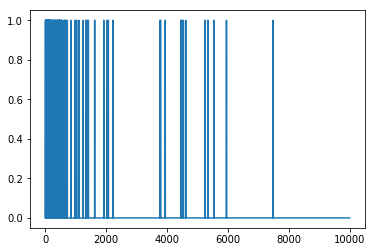

In [3]:
plt.plot(train_data[0])

## Demonstrate overfitting

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data. 

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or what the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss. Let's try this on our movie review classification network. 

We'll create a simple model using only ```Dense``` layers as a baseline, then create smaller and larger versions, and compare them.

### Create a baseline model

In [4]:
baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works. 
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [5]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.5061 - acc: 0.7994 - binary_crossentropy: 0.5061 - val_loss: 0.3577 - val_acc: 0.8688 - val_binary_crossentropy: 0.3577
Epoch 2/20
 - 3s - loss: 0.2633 - acc: 0.9063 - binary_crossentropy: 0.2633 - val_loss: 0.2858 - val_acc: 0.8862 - val_binary_crossentropy: 0.2858
Epoch 3/20
 - 2s - loss: 0.1904 - acc: 0.9329 - binary_crossentropy: 0.1904 - val_loss: 0.2867 - val_acc: 0.8855 - val_binary_crossentropy: 0.2867
Epoch 4/20
 - 3s - loss: 0.1520 - acc: 0.9479 - binary_crossentropy: 0.1520 - val_loss: 0.3081 - val_acc: 0.8803 - val_binary_crossentropy: 0.3081
Epoch 5/20
 - 2s - loss: 0.1259 - acc: 0.9577 - binary_crossentropy: 0.1259 - val_loss: 0.3338 - val_acc: 0.8756 - val_binary_crossentropy: 0.3338
Epoch 6/20
 - 2s - loss: 0.1051 - acc: 0.9666 - binary_crossentropy: 0.1051 - val_loss: 0.3628 - val_acc: 0.8707 - val_binary_crossentropy: 0.3628
Epoch 7/20
 - 3s - loss: 0.0885 - acc: 0.9732 - binary_crossentropy:

### Create a smaller model

Let's create a model with less hidden units to compare against the baseline model that we just created:

In [6]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


And train the model using the same data:

In [7]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.5900 - acc: 0.7501 - binary_crossentropy: 0.5900 - val_loss: 0.4736 - val_acc: 0.8566 - val_binary_crossentropy: 0.4736
Epoch 2/20
 - 2s - loss: 0.3797 - acc: 0.8898 - binary_crossentropy: 0.3797 - val_loss: 0.3606 - val_acc: 0.8765 - val_binary_crossentropy: 0.3606
Epoch 3/20
 - 2s - loss: 0.2859 - acc: 0.9136 - binary_crossentropy: 0.2859 - val_loss: 0.3135 - val_acc: 0.8859 - val_binary_crossentropy: 0.3135
Epoch 4/20
 - 2s - loss: 0.2362 - acc: 0.9259 - binary_crossentropy: 0.2362 - val_loss: 0.2946 - val_acc: 0.8876 - val_binary_crossentropy: 0.2946
Epoch 5/20
 - 3s - loss: 0.2044 - acc: 0.9353 - binary_crossentropy: 0.2044 - val_loss: 0.2882 - val_acc: 0.8871 - val_binary_crossentropy: 0.2882
Epoch 6/20
 - 2s - loss: 0.1810 - acc: 0.9415 - binary_crossentropy: 0.1810 - val_loss: 0.2847 - val_acc: 0.8868 - val_binary_crossentropy: 0.2847
Epoch 7/20
 - 3s - loss: 0.1626 - acc: 0.9485 - binary_crossentropy:

### Create a bigger model

As an exercise, you can create an even larger model, and see how quickly it begins overfitting.  Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [8]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


And, again, train the model using the same data:

In [9]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 10s - loss: 0.3488 - acc: 0.8526 - binary_crossentropy: 0.3488 - val_loss: 0.2940 - val_acc: 0.8824 - val_binary_crossentropy: 0.2940
Epoch 2/20
 - 10s - loss: 0.1374 - acc: 0.9502 - binary_crossentropy: 0.1374 - val_loss: 0.3555 - val_acc: 0.8646 - val_binary_crossentropy: 0.3555
Epoch 3/20
 - 12s - loss: 0.0450 - acc: 0.9872 - binary_crossentropy: 0.0450 - val_loss: 0.4299 - val_acc: 0.8696 - val_binary_crossentropy: 0.4299
Epoch 4/20
 - 13s - loss: 0.0074 - acc: 0.9990 - binary_crossentropy: 0.0074 - val_loss: 0.5848 - val_acc: 0.8707 - val_binary_crossentropy: 0.5848
Epoch 5/20
 - 14s - loss: 0.0011 - acc: 1.0000 - binary_crossentropy: 0.0011 - val_loss: 0.6694 - val_acc: 0.8708 - val_binary_crossentropy: 0.6694
Epoch 6/20
 - 11s - loss: 2.6951e-04 - acc: 1.0000 - binary_crossentropy: 2.6951e-04 - val_loss: 0.7124 - val_acc: 0.8706 - val_binary_crossentropy: 0.7124
Epoch 7/20
 - 9s - loss: 1.4248e-04 - acc: 1.0000 - bi

### Plot the training and validation loss

<!--TODO(markdaoust): This should be a one-liner with tensorboard -->

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model). Here, the smaller network begins overfitting later than the baseline model (after 6 epochs rather than 4) and its performance degrades much more slowly once it starts overfitting. 

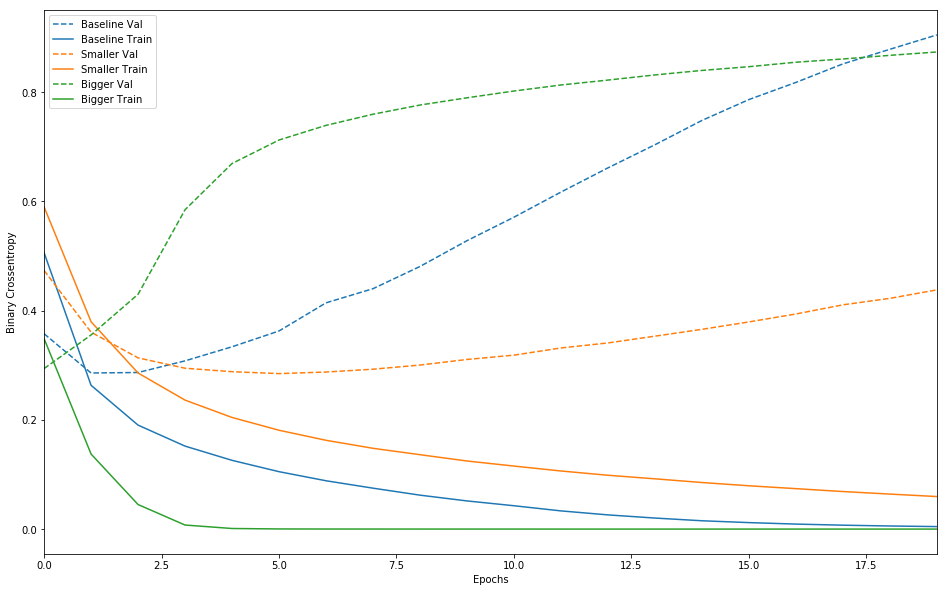

In [10]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

Notice that the larger network begins overfitting almost right away, after just one epoch, and overfits much more severely. The more capacity the network has, the quicker it will be able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss).

## Strategies

### Add weight regularization



You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [11]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.5282 - acc: 0.7991 - binary_crossentropy: 0.4854 - val_loss: 0.3844 - val_acc: 0.8768 - val_binary_crossentropy: 0.3405
Epoch 2/20
 - 3s - loss: 0.3091 - acc: 0.9088 - binary_crossentropy: 0.2614 - val_loss: 0.3371 - val_acc: 0.8876 - val_binary_crossentropy: 0.2865
Epoch 3/20
 - 3s - loss: 0.2583 - acc: 0.9287 - binary_crossentropy: 0.2055 - val_loss: 0.3373 - val_acc: 0.8870 - val_binary_crossentropy: 0.2828
Epoch 4/20
 - 4s - loss: 0.2329 - acc: 0.9393 - binary_crossentropy: 0.1769 - val_loss: 0.3467 - val_acc: 0.8833 - val_binary_crossentropy: 0.2898
Epoch 5/20
 - 3s - loss: 0.2193 - acc: 0.9458 - binary_crossentropy: 0.1609 - val_loss: 0.3586 - val_acc: 0.8803 - val_binary_crossentropy: 0.2994
Epoch 6/20
 - 3s - loss: 0.2060 - acc: 0.9516 - binary_crossentropy: 0.1462 - val_loss: 0.3714 - val_acc: 0.8769 - val_binary_crossentropy: 0.3112
Epoch 7/20
 - 3s - loss: 0.1984 - acc: 0.9539 - binary_crossentropy:

```l2(0.001)``` means that every coefficient in the weight matrix of the layer will add ```0.001 * weight_coefficient_value**2``` to the total loss of the network. Note that because this penalty is only added at training time, the loss for this network will be much higher at training than at test time.

Here's the impact of our L2 regularization penalty:

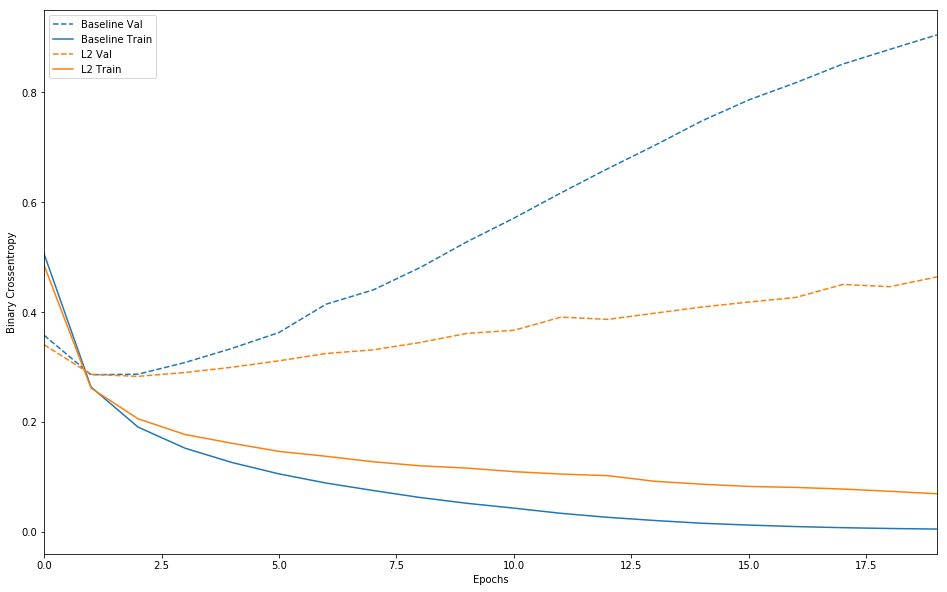

In [12]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

As you can see, the L2 regularized model has become much more resistant to overfitting than the baseline model, even though both models have the same number of parameters.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 
1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In tf.keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our IMDB network to see how well they do at reducing overfitting:

In [13]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.6172 - acc: 0.6532 - binary_crossentropy: 0.6172 - val_loss: 0.4730 - val_acc: 0.8560 - val_binary_crossentropy: 0.4730
Epoch 2/20
 - 3s - loss: 0.4503 - acc: 0.8118 - binary_crossentropy: 0.4503 - val_loss: 0.3336 - val_acc: 0.8831 - val_binary_crossentropy: 0.3336
Epoch 3/20
 - 3s - loss: 0.3453 - acc: 0.8670 - binary_crossentropy: 0.3453 - val_loss: 0.2813 - val_acc: 0.8887 - val_binary_crossentropy: 0.2813
Epoch 4/20
 - 2s - loss: 0.2835 - acc: 0.8993 - binary_crossentropy: 0.2835 - val_loss: 0.2735 - val_acc: 0.8890 - val_binary_crossentropy: 0.2735
Epoch 5/20
 - 3s - loss: 0.2404 - acc: 0.9169 - binary_crossentropy: 0.2404 - val_loss: 0.2784 - val_acc: 0.8880 - val_binary_crossentropy: 0.2784
Epoch 6/20
 - 3s - loss: 0.2099 - acc: 0.9305 - binary_crossentropy: 0.2099 - val_loss: 0.2916 - val_acc: 0.8860 - val_binary_crossentropy: 0.2916
Epoch 7/20
 - 3s - loss: 0.1820 - acc: 0.9382 - binary_crossentropy:

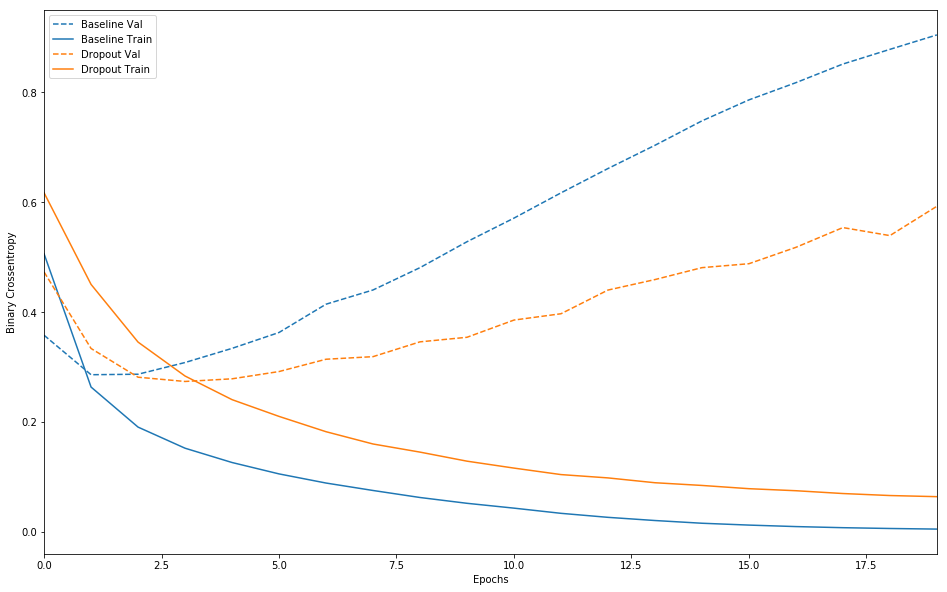

In [14]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

Adding dropout is a clear improvement over the baseline model. 


To recap: here the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

And two important approaches not covered in this guide are data-augmentation and batch normalization.